# ML Models with Sampled NYC Taxi Trip and Fare Dataset 

##### Here we show some features and capabilities of Spark's MLlib toolkit for ML problems using the NYC taxi trip and fare data-set from 2013. We take a 0.1% sample of this data-set (about 170K rows) to to show MLlib's modeling features for binary classification and regression problems using this data-set. We have shown relevant plots in Python.

OBJECTIVE: Show use of MLlib's functions for ML tasks on a small dataset (~35 Mb).

ORGANIZATION: We have organized this walkthrough into 5 major sections: 
1. Data ingestion
2. Data exploration and visualization
3. Data preparation, including feature transformation
4. Modeling: binary classification problem (tipped: 1/0), regression problem (tip amount $) 
6. Saving or persisting models in blob for future consumption

Majority of the modeling examples are shown for the binary classification problem. We have added simpler examples for the regression task; with additional samples (e.g. CV with parameter sweeping) provided in the appendix section. 

### Introductory materials

1. How to provision a HDI cluster running Spark: 
https://azure.microsoft.com/en-us/documentation/articles/hdinsight-apache-spark-zeppelin-notebook-jupyter-spark-sql/

2. NYC 2013 Taxi data:
http://www.andresmh.com/nyctaxitrips/
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/

### Settting Directory Paths in Mapped Blob Storage Prior to Running

Where models/files are being saved in the blob, the path needs to be specified properly. Default container which is attached to the Spark cluster can be referenced as: "wasb//".

Here we saved models to : "wasb:///user/remoteuser/NYCTaxi/Models/". If the path to folder is incorrect, models will not be saved where you want.

### Set directory paths and location of files

In [1]:
# 1. Location of training data
taxi_train_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Train.tsv";
#taxi_train_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.1Pct.Train.tsv";

# 2. Set model storage directory path. This is where models will be saved.
modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; # The last backslash is needed;

#### PRINT START TIME

In [2]:
import datetime
datetime.datetime.now()

datetime.datetime(2016, 4, 18, 17, 30, 8, 627660)

## Set spark context and import necessary libraries

In [3]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime
#from azure.storage.blob import BlobService

sc = SparkContext(conf=SparkConf().setMaster('yarn-client'))
sqlContext = SQLContext(sc)
atexit.register(lambda: sc.stop())

sc.defaultParallelism

4

## Data ingestion: Read in joined 0.1% taxi trip and fare file (as tsv), format and clean data, and create data-frame

The taxi trip and fare files were joined based on the instructions provided in: 
"https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/"

A 0.1% sample of the joined data-set was taken to show the ML examples in this walkthrough.

In [4]:
timestart = datetime.datetime.now()

## IMPORT FILE FROM PUBLIC BLOB
taxi_train_file = sc.textFile(taxi_train_file_loc)

## GET SCHEMA OF THE FILE FROM HEADER
schema_string = taxi_train_file.first()
fields = [StructField(field_name, StringType(), True) for field_name in schema_string.split('\t')]
fields[7].dataType = IntegerType() #Pickup hour
fields[8].dataType = IntegerType() # Pickup week
fields[9].dataType = IntegerType() # Weekday
fields[10].dataType = IntegerType() # Passenger count
fields[11].dataType = FloatType() # Trip time in secs
fields[12].dataType = FloatType() # Trip distance
fields[19].dataType = FloatType() # Fare amount
fields[20].dataType = FloatType() # Surcharge
fields[21].dataType = FloatType() # Mta_tax
fields[22].dataType = FloatType() # Tip amount
fields[23].dataType = FloatType() # Tolls amount
fields[24].dataType = FloatType() # Total amount
fields[25].dataType = IntegerType() # Tipped or not
fields[26].dataType = IntegerType() # Tip class
taxi_schema = StructType(fields)

## PARSE FIELDS AND CONVERT DATA TYPE FOR SOME FIELDS
taxi_header = taxi_train_file.filter(lambda l: "medallion" in l)
taxi_temp = taxi_train_file.subtract(taxi_header).map(lambda k: k.split("\t"))\
        .map(lambda p: (p[0],p[1],p[2],p[3],p[4],p[5],p[6],int(p[7]),int(p[8]),int(p[9]),int(p[10]),
                        float(p[11]),float(p[12]),p[13],p[14],p[15],p[16],p[17],p[18],float(p[19]),
                        float(p[20]),float(p[21]),float(p[22]),float(p[23]),float(p[24]),int(p[25]),int(p[26])))

    
## CREATE DATA FRAME
taxi_train_df = sqlContext.createDataFrame(taxi_temp, taxi_schema)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_train_cleaned = taxi_train_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )


## CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY
taxi_df_train_cleaned.cache()
taxi_df_train_cleaned.count()

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_train_cleaned.registerTempTable("taxi_train")

## PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 22.33 seconds


## Data exploration & visualization: Plotting of target variables and features

### Summarize or filter data using SQL and plotting

#### Plot frequency of passenger counts in taxi trips

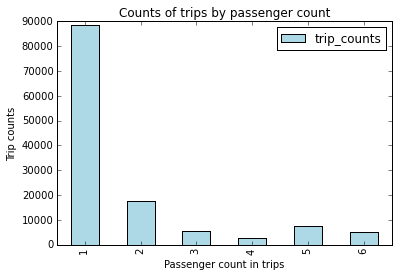

In [5]:
## SQL SQUERY
sqlStatement = """
    SELECT passenger_count, COUNT(*) as trip_counts 
    FROM taxi_train 
    WHERE passenger_count > 0 and passenger_count < 7
    GROUP BY passenger_count 
"""
sqlResults = sqlContext.sql(sqlStatement)

#CONVERT TO PANDAS DATA-FRAMES FOR PLOTTING IN PYTHON
resultsPDDF = sqlResults.toPandas()

## PLOT PASSENGER NUMBER VS. TRIP COUNTS
x_labels = resultsPDDF['passenger_count'].values
fig = resultsPDDF[['trip_counts']].plot(kind='bar', facecolor='lightblue')
fig.set_xticklabels(x_labels)
fig.set_title('Counts of trips by passenger count')
fig.set_xlabel('Passenger count in trips')
fig.set_ylabel('Trip counts')
plt.show()

#### Plot histogram of tip amount, relationship between tip amount vs. other features

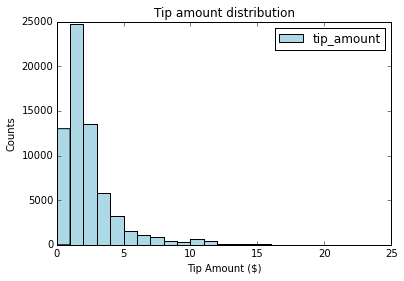

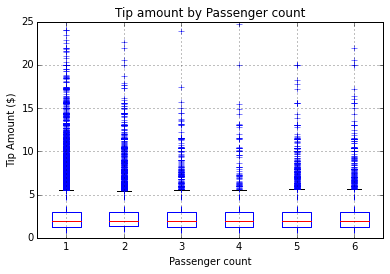

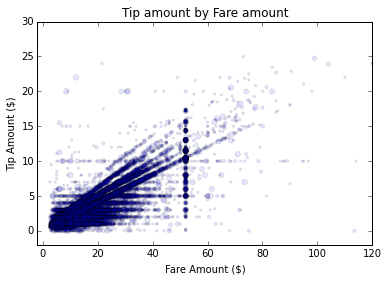

Time taken to execute above cell: 10.79 seconds


In [6]:
timestart = datetime.datetime.now()

### SQL SQUERY
sqlStatement = """
    SELECT fare_amount, passenger_count, tip_amount, tipped
    FROM taxi_train 
    WHERE passenger_count > 0 AND passenger_count < 7
    AND fare_amount > 0 AND fare_amount < 200
    AND payment_type in ('CSH', 'CRD')
    AND tip_amount > 0 AND tip_amount < 25
"""
sqlResults = sqlContext.sql(sqlStatement)

#CONVERT TO PANDAS DATA-FRAME FOR PLOTTING IN PYTHON
resultsPDDF = sqlResults.toPandas()

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = resultsPDDF[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

# TIP BY PASSENGER COUNT
ax2 = resultsPDDF.boxplot(column=['tip_amount'], by=['passenger_count'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Tip Amount ($)')
plt.suptitle('')
plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = resultsPDDF.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=5*(resultsPDDF.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Tip Amount ($)')
plt.axis([-2, 120, -2, 30])
plt.show()

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

## Feature engineering, transformation and data prep for modeling

#### Create a new feature by binning hours into traffic time buckets

In [7]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """
    SELECT *,
    CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
taxi_df_train_with_newFeatures = sqlContext.sql(sqlStatement)

## CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY
taxi_df_train_with_newFeatures.cache()
taxi_df_train_with_newFeatures.count()

126050

#### Indexing and one-hot encoding of categorical features

Here we only transform three variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

In [8]:
timestart = datetime.datetime.now()

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, VectorIndexer

stringIndexer = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex")
model = stringIndexer.fit(taxi_df_train_with_newFeatures) # Input data-frame is the cleaned one from above
indexed = model.transform(taxi_df_train_with_newFeatures)
encoder = OneHotEncoder(dropLast=False, inputCol="vendorIndex", outputCol="vendorVec")
encoded1 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="rate_code", outputCol="rateIndex")
model = stringIndexer.fit(encoded1)
indexed = model.transform(encoded1)
encoder = OneHotEncoder(dropLast=False, inputCol="rateIndex", outputCol="rateVec")
encoded2 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="payment_type", outputCol="paymentIndex")
model = stringIndexer.fit(encoded2)
indexed = model.transform(encoded2)
encoder = OneHotEncoder(dropLast=False, inputCol="paymentIndex", outputCol="paymentVec")
encoded3 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex")
model = stringIndexer.fit(encoded3)
indexed = model.transform(encoded3)
encoder = OneHotEncoder(dropLast=False, inputCol="TrafficTimeBinsIndex", outputCol="TrafficTimeBinsVec")
encodedFinal = encoder.transform(indexed)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 2.94 seconds


#### Functions for creating labeledpoint RDD objects for input into logistic regression model, where categorical variables are included with one-hot encoding

Labeled point objects are particular RDD formatd that is needed as input data in most of MLlib's ML algorithms. In Labeled point objects, each observation is represented by a vector of features and the target label.

###### Functions for binary classification: tipped (/10) as binary target variable

In [9]:
from pyspark.mllib.regression import LabeledPoint
from numpy import array

# INDEXING CATEGORICAL TEXT FEATURES FOR INPUT INTO TREE-BASED MODELS
def parseRowIndexingBinary(line):
    features = np.array([line.paymentIndex, line.vendorIndex, line.rateIndex, line.TrafficTimeBinsIndex,
                         line.pickup_hour, line.weekday, line.passenger_count, line.trip_time_in_secs, 
                         line.trip_distance, line.fare_amount])
    labPt = LabeledPoint(line.tipped, features)
    return  labPt

# ONE-HOT ENCODING OF CATEGORICAL TEXT FEATURES FOR INPUT INTO LOGISTIC RERESSION MODELS
def parseRowOneHotBinary(line):
    features = np.concatenate((np.array([line.pickup_hour, line.weekday, line.passenger_count,
                                        line.trip_time_in_secs, line.trip_distance, line.fare_amount]), 
                                        line.vendorVec.toArray(), line.rateVec.toArray(), 
                                        line.paymentVec.toArray(), line.TrafficTimeBinsVec.toArray()), axis=0)
    labPt = LabeledPoint(line.tipped, features)
    return  labPt

###### Functions for regression: tip amount ($) as target variable

In [10]:
# ONE-HOT ENCODING OF CATEGORICAL TEXT FEATURES FOR INPUT INTO TREE-BASED MODELS
def parseRowIndexingRegression(line):
    features = np.array([line.paymentIndex, line.vendorIndex, line.rateIndex, line.TrafficTimeBinsIndex, 
                         line.pickup_hour, line.weekday, line.passenger_count, line.trip_time_in_secs, 
                         line.trip_distance, line.fare_amount])
    labPt = LabeledPoint(line.tip_amount, features)
    return  labPt

# INDEXING CATEGORICAL TEXT FEATURES FOR INPUT INTO LINEAR REGRESSION MODELS
def parseRowOneHotRegression(line):
    features = np.concatenate((np.array([line.pickup_hour, line.weekday, line.passenger_count,
                                        line.trip_time_in_secs, line.trip_distance, line.fare_amount]), 
                                        line.vendorVec.toArray(), line.rateVec.toArray(), 
                                        line.paymentVec.toArray(), line.TrafficTimeBinsVec.toArray()), axis=0)
    labPt = LabeledPoint(line.tip_amount, features)
    return  labPt

#### Create a random sampling of the data, as needed (25% is used here). This can save some time while training models. Then, split into train/test, and create one-hot encoded or indexed train/test Labeled point data objects for input into MLlib

In [11]:
timestart = datetime.datetime.now()

# SPECIFY SAMPLING AND SPLITTING FRACTIONS
from pyspark.sql.functions import rand

samplingFraction = 0.25;
trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;
encodedFinalSampled = encodedFinal.sample(False, samplingFraction, seed=seed)

# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
# INCLUDE RAND COLUMN FOR CREATING CROSS-VALIDATION FOLDS
dfTmpRand = encodedFinalSampled.select("*", rand(0).alias("rand"));
trainData, testData = dfTmpRand.randomSplit([trainingFraction, testingFraction], seed=seed);

# FOR BINARY CLASSIFICATION TRAINING AND TESTING
indexedTRAINbinary = trainData.map(parseRowIndexingBinary)
indexedTESTbinary = testData.map(parseRowIndexingBinary)
oneHotTRAINbinary = trainData.map(parseRowOneHotBinary)
oneHotTESTbinary = testData.map(parseRowOneHotBinary)

# FOR REGRESSION TRAINING AND TESTING
indexedTRAINreg = trainData.map(parseRowIndexingRegression)
indexedTESTreg = testData.map(parseRowIndexingRegression)
oneHotTRAINreg = trainData.map(parseRowOneHotRegression)
oneHotTESTreg = testData.map(parseRowOneHotRegression)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 0.32 seconds


#### Feature scaling can be important for some ML algos, e.g. regularized regressionons or SVM. Here we show feature scaling for use with LinearRegressionwithSGD

In [12]:
timestart = datetime.datetime.now()

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.util import MLUtils

# SCALE VARIABLES FOR REGULARIZED LINEAR SGD ALGO: We have found LinearRegressionWithSGD to be sensitive to feature scaling
label = oneHotTRAINreg.map(lambda x: x.label)
features = oneHotTRAINreg.map(lambda x: x.features)
scaler = StandardScaler(withMean=False, withStd=True).fit(features)
dataTMP = label.zip(scaler.transform(features.map(lambda x: Vectors.dense(x.toArray()))))
oneHotTRAINregScaled = dataTMP.map(lambda x: LabeledPoint(x[0], x[1]))

label = oneHotTESTreg.map(lambda x: x.label)
features = oneHotTESTreg.map(lambda x: x.features)
scaler = StandardScaler(withMean=False, withStd=True).fit(features)
dataTMP = label.zip(scaler.transform(features.map(lambda x: Vectors.dense(x.toArray()))))
oneHotTESTregScaled = dataTMP.map(lambda x: LabeledPoint(x[0], x[1]))

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 7.91 seconds


#### Cache RDDs and DF Objects for faster running of algorithms with cached objects

In [13]:
timestart = datetime.datetime.now()

# FOR BINARY CLASSIFICATION TRAINING AND TESTING
indexedTRAINbinary.cache()
indexedTESTbinary.cache()
oneHotTRAINbinary.cache()
oneHotTESTbinary.cache()

# FOR REGRESSION TRAINING AND TESTING
indexedTRAINreg.cache()
indexedTESTreg.cache()
oneHotTRAINreg.cache()
oneHotTESTreg.cache()

# SCALED FEATURES
oneHotTRAINregScaled.cache()
oneHotTESTregScaled.cache()

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 0.15 seconds


## Binary classification model training: Predicting tip or no tip (target: tipped = 1/0)

###### We address two learning problems
1. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip
2. Regression problem: Prediction of the tip amonut ($)


Each model building setion will be split into steps: 
1. Model training data with one parameter set
2. Model evaluation on a test data set with metrics
3. Saving model in blob for future consumption


For each learning problem (binary classification or regression), we present a linear (logistic or linear regression) approach, followed by Random Forest and Boosted Trees.

### Logistic regression (LogisticRegressionWithLBFGS) with CV and hyperparameter sweeping. Includes evaluation of test data-set, and saving model for consumption

Area under PR = 0.985319161941
Area under ROC = 0.983511076103
Summary Stats
Precision = 0.984187223276
Recall = 0.984187223276
F1 Score = 0.984187223276


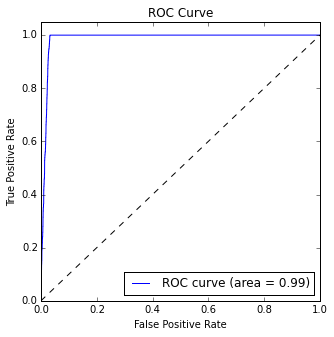

Time taken to execute above cell: 31.02 seconds


In [14]:
# GET ACCURARY FOR HYPERPARAMETERS VASED ON CROSS-VALIDATION IN TRAINING DATA-SET
timestart = datetime.datetime.now()

from pyspark.mllib.classification import LogisticRegressionWithLBFGS 
from sklearn.metrics import roc_curve,auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics


# CREATE MODEL WITH ONE SET OF PARAMETERS
logitModel = LogisticRegressionWithLBFGS.train(oneHotTRAINbinary, iterations=20, initialWeights=None, 
                                               regParam=0.01, regType='l2', intercept=True, corrections=10, 
                                               tolerance=0.0001, validateData=True, numClasses=2)

# PREDICT ON TEST DATA WITH MODEL
predictionAndLabels = oneHotTESTbinary.map(lambda lp: (float(logitModel.predict(lp.features)), lp.label))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)
# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)
metrics = MulticlassMetrics(predictionAndLabels)
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# CREATE A PANDAS DATA-FRAME AND PLOT ROC-CURVE, FROM PREDICTED PROBS AND LABELS                                     
logitModel.clearThreshold(); # This clears threshold for classification (0.5) and outputs probabilities
predictionAndLabelsDF = predictionAndLabels.toDF()
test_predictions = predictionAndLabelsDF.toPandas()
predictions_pddf = test_predictions.rename(columns={'_1': 'probability', '_2': 'label'})

prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(predictions_pddf['label'], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## SAVE MODEL WITH DATE-STAMP
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
logisticregressionfilename = "LogisticRegressionWithLBFGS_" + datestamp;
dirfilename = modelDir + logisticregressionfilename;

logitModel.save(sc, dirfilename);

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

### Random forest binary classification: modeling, evaluation, saving

In [15]:
timestart = datetime.datetime.now()

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# SPECIFY NUMBER OF CATEGORIES FOR CATEGORICAL FEATURES. FEATURE #0 HAS 2 CATEGORIES, FEATURE #2 HAS 2 CATEGORIES, AND SO ON
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}

# TRAIN RANDOMFOREST MODEL
rfModel = RandomForest.trainClassifier(indexedTRAINbinary, numClasses=2, 
                                       categoricalFeaturesInfo=categoricalFeaturesInfo,
                                       numTrees=25, featureSubsetStrategy="auto",
                                       impurity='gini', maxDepth=5, maxBins=32)
## UN-COMMENT IF YOU WANT TO PRINT TREES
#print('Learned classification forest model:')
#print(rfModel.toDebugString())

# PREDICT ON TEST DATA AND EVALUATE
predictions = rfModel.predict(indexedTESTbinary.map(lambda x: x.features))
predictionAndLabels = indexedTESTbinary.map(lambda lp: lp.label).zip(predictions)

# Area under ROC curve
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# PERSIST MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rfclassificationfilename = "RandomForestClassification_" + datestamp;
dirfilename = modelDir + rfclassificationfilename;

rfModel.save(sc, dirfilename);

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Area under ROC = 0.985240932843
Time taken to execute above cell: 28.7 seconds


### Gradient boosting tree binary classification: modeling, evaluation, saving

In [16]:
timestart = datetime.datetime.now()

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel

# SPECIFY NUMBER OF CATEGORIES FOR CATEGORICAL FEATURES. FEATURE #0 HAS 2 CATEGORIES, FEATURE #2 HAS 2 CATEGORIES, AND SO ON
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}

gbtModel = GradientBoostedTrees.trainClassifier(indexedTRAINbinary, categoricalFeaturesInfo=categoricalFeaturesInfo, numIterations=5)
## UNCOMMENT IF YOU WANT TO PRINT TREE DETAILS
#print('Learned classification GBT model:')
#print(bgtModel.toDebugString())

# PREDICT ON TEST DATA AND EVALUATE
predictions = gbtModel.predict(indexedTESTbinary.map(lambda x: x.features))
predictionAndLabels = indexedTESTbinary.map(lambda lp: lp.label).zip(predictions)

# Area under ROC curve
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# PERSIST MODEL IN A BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
btclassificationfilename = "GradientBoostingTreeClassification_" + datestamp;
dirfilename = modelDir + btclassificationfilename;

gbtModel.save(sc, dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Area under ROC = 0.985240932843
Time taken to execute above cell: 16.47 seconds


## Regression model training: Predicting tip amount ($)

### Linear regression with stochastic gradient descent (SGD): modeling, evaluation, saving

NOTE: In our experience, there can be frequent issues with convergance of LinearRegressionWithSGD models, and parameters need to be changed/optimized carefully for obtainig a valid model. Scaling of variables significantly helps (shown below). One can also use the elastic net regression which is shown below in the Appendix.

In [17]:
timestart = datetime.datetime.now()

from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.evaluation import RegressionMetrics
from scipy import stats

# USE SCALED FEATURES TO TRAIN MODEL
linearModel = LinearRegressionWithSGD.train(oneHotTRAINregScaled, iterations=100, step = 0.1, regType='l2', regParam=0.1, intercept = True)

# SCORE ON SCALED TEST DATA-SET & EVALUATE
predictionAndLabels = oneHotTESTregScaled.map(lambda lp: (float(linearModel.predict(lp.features)), lp.label))
testMetrics = RegressionMetrics(predictionAndLabels)

print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# SAVE MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
linearregressionfilename = "LinearRegressionWithSGD_" + datestamp;
dirfilename = modelDir + linearregressionfilename;

linearModel.save(sc, dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 1.29395294535
R-sqr = 0.588405443258
Time taken to execute above cell: 44.49 seconds


### Random Forest Regression: modeling, evaluation, saving

In [18]:
timestart= datetime.datetime.now()
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import RegressionMetrics


## TRAIN MODEL
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}
rfModel = RandomForest.trainRegressor(indexedTRAINreg, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                    numTrees=25, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=32)
## UN-COMMENT IF YOU WANT TO PRING TREES
#print('Learned classification forest model:')
#print(rfModel.toDebugString())

## PREDICT AND EVALUATE ON TEST DATA-SET
predictions = rfModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = oneHotTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# SAVE MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rfregressionfilename = "RandomForestRegression_" + datestamp;
dirfilename = modelDir + rfregressionfilename;

rfModel.save(sc, dirfilename);

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 0.947134121707
R-sqr = 0.702688590021
Time taken to execute above cell: 35.27 seconds


### Gradient boosting trees regression: modeling, evaluation, saving

RMSE = 0.960384741487
R-sqr = 0.707581489253


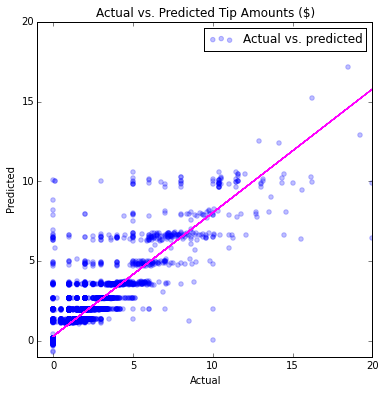

Time taken to execute above cell: 59.68 seconds


In [19]:
### timestart= datetime.datetime.now()

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

## TRAIN MODEL
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}
gbtModel = GradientBoostedTrees.trainRegressor(indexedTRAINreg, categoricalFeaturesInfo=categoricalFeaturesInfo, 
                                                numIterations=10, maxBins=32, maxDepth = 4, learningRate=0.1)

## EVALUATE A TEST DATA-SET
predictions = gbtModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = indexedTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# PLOT SCATTER-PLOT BETWEEN ACTUAL AND PREDICTED TIP VALUES
test_predictions = sqlContext.createDataFrame(predictionAndLabels)
test_predictions_pddf = test_predictions.toPandas()

ax = test_predictions_pddf.plot(kind='scatter', figsize = (6,6), x='_1', y='_2', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(test_predictions_pddf['_1'], test_predictions_pddf['_2'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(test_predictions_pddf['_1'], fit[0] * test_predictions_pddf['_1'] + fit[1], color='magenta')
plt.axis([-1, 20, -1, 20])
plt.show(ax)

# SAVE MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
btregressionfilename = "GradientBoostingTreeRegression_" + datestamp;
dirfilename = modelDir + btregressionfilename;

gbtModel.save(sc, dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

## Cleanup objects from memory, print final time, and print model locations

#### Unpersist objects cached in memory

In [20]:
# REMOVE ORIGINAL DFs
taxi_df_train_cleaned.unpersist()
taxi_df_train_with_newFeatures.unpersist()

# FOR BINARY CLASSIFICATION TRAINING AND TESTING
indexedTRAINbinary.unpersist()
indexedTESTbinary.unpersist()
oneHotTRAINbinary.unpersist()
oneHotTESTbinary.unpersist()

# FOR REGRESSION TRAINING AND TESTING
indexedTRAINreg.unpersist()
indexedTESTreg.unpersist()
oneHotTRAINreg.unpersist()
oneHotTESTreg.unpersist()

# SCALED FEATURES
oneHotTRAINregScaled.unpersist()
oneHotTESTregScaled.unpersist()

PythonRDD[115] at RDD at PythonRDD.scala:43

#### Print out path to model files to be used in the consumption notebook
For consumption and scoring an independent data-set, you will need to copy and paste these file names in the "Consumption notebook".

In [21]:
## MODEL FILE LOCATIONS FOR CONSUMPTION
print "logisticRegFileLoc = modelDir + \"" + logisticregressionfilename + "\"";
print "linearRegFileLoc = modelDir + \"" + linearregressionfilename + "\"";
print "randomForestClassificationFileLoc = modelDir + \"" + rfclassificationfilename + "\"";
print "randomForestRegFileLoc = modelDir + \"" + rfregressionfilename + "\"";
print "BoostedTreeClassificationFileLoc = modelDir + \"" + btclassificationfilename + "\"";
print "BoostedTreeRegressionFileLoc = modelDir + \"" + btregressionfilename + "\"";

logisticRegFileLoc = modelDir + "LogisticRegressionWithLBFGS_2016-04-1817_31_45.670367"
linearRegFileLoc = modelDir + "LinearRegressionWithSGD_2016-04-1817_33_15.618269"
randomForestClassificationFileLoc = modelDir + "RandomForestClassification_2016-04-1817_32_10.497538"
randomForestRegFileLoc = modelDir + "RandomForestRegression_2016-04-1817_33_45.476867"
BoostedTreeClassificationFileLoc = modelDir + "GradientBoostingTreeClassification_2016-04-1817_32_30.726550"
BoostedTreeRegressionFileLoc = modelDir + "GradientBoostingTreeRegression_2016-04-1817_34_13.236977"


#### Print finish time

In [22]:
datetime.datetime.now()

datetime.datetime(2016, 4, 18, 17, 34, 24, 651390)